# Nonlinear Elasticity in a multipatch domain


In [58]:
%pylab inline
import scipy
import itertools

from pyiga import bspline, assemble, vform, geometry, vis, solvers

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# assemble matrix
from scipy.sparse import coo_matrix, block_diag, bmat

# line search
from scipy.optimize import line_search

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\MHeig\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['solve', 'bmat', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [59]:
# 3 D #
p = 2 # spline degree 
n_el = (6, 3, 3)  # number of elements in x, y, z direction, isotropic material
# displacement space: degree p,   continuity p-1
kvs_u = tuple(bspline.make_knots(p, 0.0, 1.0, n, mult=1) for n in n_el) # or : mult=2
m_u = tuple(kv.numdofs for kv in kvs_u)


In [60]:
def grid_eval(f, grid):
    """Evaluate function `f` over the tensor grid `grid`."""
    if hasattr(f, 'grid_eval'):
        return f.grid_eval(grid)
    else:
        mesh = np.meshgrid(*grid, sparse=True, indexing='ijk')
        mesh.reverse() # convert order ZYX into XYZ
        values = f(*mesh)
        return _ensure_grid_shape(values, grid)

In [61]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection
from mpl_toolkits import mplot3d

def plot_geo(geo, grid=10, gridx=None, gridy=None, gridz= None,
             res=30,
             linewidth=None, color='black',  **kwargs):
    """Plot a wireframe representation of a 2D geometry."""
    #fig = plt.figure()
    
    if geo.sdim == 1 and geo.dim == 2:
        print("plot_curve")
        return plot_curve(geo, res=res, linewidth=linewidth, color=color)
    
    #print("geo.sdim:", geo.sdim)
    #print("geo.dim:", geo.dim)
    
    if geo.dim == geo.sdim == 2:
        #assert geo.dim == geo.sdim == 2, 'Can only plot 2D geometries'
        if gridx is None: gridx = grid
        if gridy is None: gridy = grid
        supp = geo.support

        # if gridx/gridy is not an array, build an array with given number of ticks
        if np.isscalar(gridx):
            gridx = np.linspace(supp[0][0], supp[0][1], gridx)
        if np.isscalar(gridy):
            gridy = np.linspace(supp[1][0], supp[1][1], gridy)

        meshx = np.linspace(supp[0][0], supp[0][1], res)
        meshy = np.linspace(supp[1][0], supp[1][1], res)

        def plotline(pts, capstyle='butt'):
            plt.plot(pts[:, 0], pts[:, 1], color=color, linewidth=linewidth,
                     solid_joinstyle='round', solid_capstyle=capstyle)

        pts = grid_eval(geo, (gridx, meshy))
        plotline(pts[0, :, :], capstyle='round')
        for i in range(1, pts.shape[0] - 1):
            plotline(pts[i, :, :])
        plotline(pts[-1, :, :], capstyle='round')

        pts = grid_eval(geo, (meshx, gridy))
        plotline(pts[:, 0, :], capstyle='round')
        for j in range(1, pts.shape[1] - 1):
            plotline(pts[:, j, :])
        plotline(pts[:, -1, :], capstyle='round')

    
    if geo.sdim == geo.dim == 3:
        #print("3D geometry")
        # syntax for 3-D projection
        #ax = plt.axes(projection ='3d')
        #assert geo.dim == geo.sdim == 3, 'Can only plot 3D geometries'
        
        if gridx is None: gridx = grid
        if gridy is None: gridy = grid
        if gridz is None: gridz = grid
        supp = geo.support
        
        # if gridx/gridy is not an array, build an array with given number of ticks
        if np.isscalar(gridx):
            gridx = np.linspace(supp[0][0], supp[0][1], gridx)
            #print(gridx)
        if np.isscalar(gridy):
            gridy = np.linspace(supp[1][0], supp[1][1], gridy)
        if np.isscalar(gridz):
            gridz = np.linspace(supp[2][0], supp[2][1], gridz)

        meshx = np.linspace(supp[0][0], supp[0][1], res)
        #print(meshx)
        meshy = np.linspace(supp[1][0], supp[1][1], res)
        meshz = np.linspace(supp[2][0], supp[2][1], res)

        def plotline(pts, capstyle='butt'):
            ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], cmap=cm.coolwarm, linewidth=linewidth,  **kwargs)

        pts = grid_eval(geo, (gridx, meshy, meshz))# meshy
        plotline(pts[0, :, :], capstyle='round')# beginning
        for i in range(1, pts.shape[0] - 1): 
            plotline(pts[i, :, :]) # inbetween
        plotline(pts[-1, :, :], capstyle='round') # end

        pts = grid_eval(geo, (meshx, gridy, meshz))
        plotline(pts[:, 0, :], capstyle='round')
        for j in range(1, pts.shape[1] - 1):
            plotline(pts[:, j, :])
        plotline(pts[:, -1, :], capstyle='round')

        pts = grid_eval(geo, (meshx, meshy, gridz))
        plotline(pts[:, :, 0], capstyle='round')
        for k in range(1, pts.shape[2] - 1): 
            plotline(pts[:, :, k])
        plotline(pts[:, :, -1], capstyle='round')

        # plotting
        #ax.set_title('3D line plot')
        #plt.show()


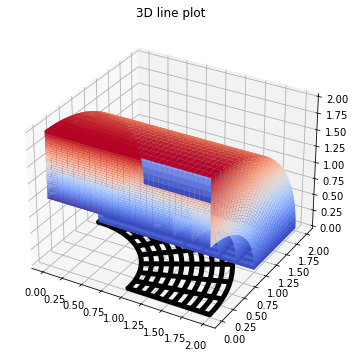

In [62]:
G = geometry.tensor_product(geometry.quarter_annulus(), geometry.line_segment(0,2))
G2 =  geometry.quarter_annulus()
#G = geometry.tensor_product(geometry.line_segment(0,1), geometry.quarter_annulus())
figsize(8,6)
fig = plt.figure()
ax = plt.axes(projection ='3d')
plot_geo(G) #vmin=0.0, vmax=2.5e-2 3D

plot_geo(G2, linewidth=5) #vmin=0.0, vmax=2.5e-2 2D
ax.set_title('3D line plot')
plt.show()

In [63]:
# define geometry
# realistic model of an artery: r_inner= 4mm, r_outer= 7mm (preprint)
# human carotid artery: r_i= 3.1 mm, r_o= 4mm (Holzapfel)
r_out = 4
r_in = 3.1
#r_out = 0.4
#r_in = 0.31

geos = [
 
    geometry.quarter_annulus(r1=r_in, r2=r_out),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(3*pi/2),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(pi),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(pi/2)
]

# 3D
#geos_3d = [geometry.tensor_product(geometry.line_segment(0,1), g) for g in geos] # z- axis
#geos_3d = [geometry.tensor_product(g, geometry.line_segment(0,1)) for g in geos]# x-axis
geos_3d = [geometry.tensor_product(g, geometry.line_segment(0,5)) for g in geos]# x-axis

In [64]:
patches_u = [(kvs_u, g) for g in geos_3d] # 3D

# Here we auto-detect the interfaces between the patches.
MP_u = assemble.Multipatch(patches_u, automatch=True) #3D

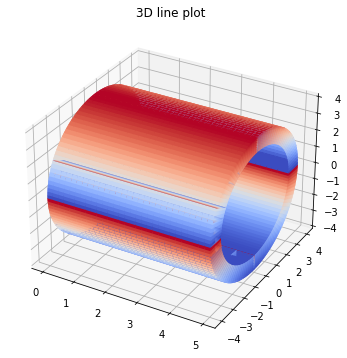

In [65]:
figsize(8,6)
fig = plt.figure()
ax = plt.axes(projection ='3d')

for g in geos_3d:
    plot_geo(g)#, vmin=0, vmax=7.5)

ax.set_title('3D line plot')
plt.show()

In [149]:
#split the solution into its components (displacement in x- and y- direction)
# visualization per patch , 2D only!
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib.ticker import LinearLocator
from matplotlib import cm
### 3d surface

def get_defplot(u, patches_u, kvs_u, grid=2, gridx=None, gridy=None, gridz= None,
             res=20, linewidth=None, color='black',  **kwargs):
    
    #u= LS.complete(u)
    """Split solution vector into displacement components."""
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:2*MP_u.numdofs]
    u3 = u[2*MP_u.numdofs:3*MP_u.numdofs]
   
    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]
    u3_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u3)
           for p in range(len(patches_u))]
    
    figsize(10,10)
    #fig, ax = plt.subplots()
    fig = plt.figure()
    ax = plt.axes(projection ='3d')
    vrange = None
    
     # visualization per patch
    for (u1_func, u2_func, u3_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 

        if gridx is None: gridx = grid
        if gridy is None: gridy = grid
        if gridz is None: gridz = grid
        supp = geo.support
        
        # if gridx/gridy is not an array, build an array with given number of ticks
        if np.isscalar(gridx):
            gridx = np.linspace(supp[0][0], supp[0][1], gridx) # e.g. linespace(0, 1, 10)
        if np.isscalar(gridy):
            gridy = np.linspace(supp[1][0], supp[1][1], gridy)
        if np.isscalar(gridz):
            gridz = np.linspace(supp[2][0], supp[2][1], gridz)

        meshx = np.linspace(supp[0][0], supp[0][1], res) # e.g. linespace(0, 1, 50)
        meshy = np.linspace(supp[1][0], supp[1][1], res)
        meshz = np.linspace(supp[2][0], supp[2][1], res)

    ## checkerboad pattern:
    # Create an empty array of strings with the same shape as the meshgrid, and
    # populate it with two colors in a checkerboard pattern.
        xlen = len(meshx)
        ylen = len(meshy)
        X, Y = np.meshgrid(meshx, meshy)
        colortuple = ('y', 'b')
        colors = np.empty(X.shape, dtype=str)
        for y in range(ylen):
            for x in range(xlen):
                 colors[y, x] = colortuple[(x + y) % len(colortuple)]
    
                
        def plotline(pts, capstyle='butt'):
            C = np.sqrt(np.power(pts[..., 1], 2) + np.power(pts[..., 2],2))
            #print(shape(C))
            #print('c',C)
            vrange = (C.min(), C.max())
            norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
            ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], linewidth=0, antialiased=False, shade = False, alpha = 0.3, 
                            facecolors=cm.viridis(C), vmin=vrange[0], vmax=vrange[1])
            #ax.plot_wireframe(pts[..., 0], pts[..., 1], pts[..., 2], linewidth=1, color='grey') # grid
            ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], facecolors=colors, linewidth=0) # checkerboard
        
        #xgridyz = (gridx , meshy, meshz)
        xgridyz = (gridx,gridx, gridx)
        ygridxz = (meshx, gridy, meshz)
        zgridxy = (meshx, meshy, gridz)
        
        # y-grid 
        dis1 = u1_func.grid_eval(ygridxz) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(ygridxz) #y-value
        dis3 = u3_func.grid_eval(ygridxz) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid
    
        pts = grid_eval(geo, ygridxz) + dis  # + displacement y-coord
    
        C = np.sqrt(np.power(dis[..., 0],2) + np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        #vrange = (C.min(), C.max())
        #norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
      
        plotline(pts[:, 0, :], capstyle='round')
        for j in range(1, pts.shape[1] - 1):
            plotline(pts[:, j, :])
        plotline(pts[:, -1, :], capstyle='round')

        # z-grid
        dis1 = u1_func.grid_eval(zgridxy) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(zgridxy) #y-value
        dis3 = u3_func.grid_eval(zgridxy) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid   
        
        pts = grid_eval(geo, zgridxy) + dis # # + displacement z-coord
        plotline(pts[:, :, 0], capstyle='round')
        for k in range(1, pts.shape[2] - 1): 
            plotline(pts[:, :, k])
        plotline(pts[:, :, -1], capstyle='round')
        
    C = np.sqrt(np.power(dis[..., 0],2) + np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
    #if vrange= None:
    vrange = (C.min(), C.max())
    norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
 
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, pad=0.2)
    
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
    plt.show()

In [67]:
class multipatch_block_handler:
    
    # Takes array of multi-patch objects
    def __init__( self, multi_patches ):
        self.multi_patches = multi_patches
        self.numpatches = multi_patches[0].numpatches
        for multi_patch in multi_patches:
            if multi_patch.numpatches != self.numpatches:
                print("Inconsistent numbers of patches")

    def patch_to_global(self, p):
        first = True
        for multi_patch in self.multi_patches:
            if first:
                X = multi_patch.patch_to_global(p)
                first = False
            else:
                X = scipy.sparse.block_diag((X,multi_patch.patch_to_global(p)))
        return X
    
    def compute_dirichlet_bcs(self, data):
        first = True
        p = 0
        offset = 0
        for multi_patch in self.multi_patches:
            data_p = []
            for item in data:
                if len(item)<4 or p in item[3]:
                    data_p.append( (item[0], item[1], lambda *x : item[2](*x)[p]) )
            if len(data_p)>0:
                bcs_p = multi_patch.compute_dirichlet_bcs(data_p)
                if first:
                    bcs = list(bcs_p)
                    first = False
                else:
                    #Indices need offset
                    bcs[0] = numpy.concatenate((bcs[0],bcs_p[0]+offset))
                    #Values are kept as-is
                    bcs[1] = numpy.concatenate((bcs[1],bcs_p[1]))
            offset += multi_patch.numdofs
            p += 1
        return tuple(bcs)
    
    def compute_local_offset_for_component(self, p, c):
        offset = 0
        for cc in range(c):
            dim = 1
            kvs, geo = self.multi_patches[cc].patches[p]
            for kv in kvs:
                dim *= kv.numdofs
            offset += dim
        return offset


In [68]:
# define boundary conditions

In [69]:
# source term f, 3D
def f(x, y, z): return (0.0, 0.0, 0.0)

In [70]:
#Neumann BC
def gN0(x, y, z): 
#quarter annulus in y/z coord.system
    #xx= linspace(0,1,10)
    #for i in range(len(xx)):
    return (0, y/r_in*loading_value, z/r_in*loading_value) # inner pressure, in normal direction (0, 1, 1)

# quarter annulus in x/y coord.system
   # return (x/r_out*loading_value, y/r_out*loading_value, 0)  #inner  pressure, normalized vector
# normal direction in z does not exist by now!


In [90]:
def g0(x,y,z):
    #if (x > 0.5).all() and (x < 0.8).all():
    if (x > 2).all() and (x < 4).all():
        #print(x)
        return loading_value # set force at distal end only
    else:
        return 0

In [91]:
def gN(x, y, z): 
    if isinstance(x,numpy.float64):
        return (0, 0, 0)
    s_y = shape(y)
    fac = [g0(xi,y, z) for xi in np.nditer(x)]
    fac= np.reshape(fac, s_y)
    return (0, y/r_in* fac, z/r_in*fac)# inner pressure

In [92]:
# Multipatch objects for all variables (x, y, z)
MP_block = multipatch_block_handler( [MP_u, MP_u, MP_u] ) 

In [93]:
# define Dirichlet boundary function 
def g_zero(x, y, z): return (0.0, 0.0, 0.0) # fixed in y/z, x runs, evtl. set x=x

# set up Dirichlet boundary conditions
bc = MP_block.compute_dirichlet_bcs([
    (1, 'top', g_zero ) # outer bd, 1
])

In [94]:
# Compute solution of nonlinear elasticity problem

In [95]:
#split the solution into its components (displacement in x- and y- direction) and convert to BSpline function
def get_components(u, kvs_u):
    """Split solution vector into displacement components."""
    #print("shape_u", shape(u))
    N = np.prod(tuple(kv.numdofs for kv in kvs_u))
    u1 = u[:N].reshape(m_u)          
    u2 = u[N:2*N].reshape(m_u)    
    u3 = u[2*N:3*N].reshape(m_u)    
    U = np.stack((u1,u2,u3), axis=-1)
    return bspline.BSplineFunc(kvs_u, U)


In [96]:
# rubber, Lamé-coeff.
Mu = 3 # [GPa]
Lam = 0.28416 #  [GPa] (under ass. ny=0.48, almost incompressible)
#Mu = 0.003 # [GPa]
#Lam = 0.00028416 #  [GPa] (under ass. ny=0.48, almost incompressible)
# incompressible: Lam = 0

def mass_nl(u_p, kvs_ux, geo_ux, X):
    M = assemble.assemble('inner(u, v) * dx', kvs_ux, bfuns=[('u',3), ('v',3)], geo=geo_ux) #matrix M
    return M
    

# nonlinear variational form
def apply_nl(u_p, kvs_ux, geo_ux, X):
    dis = get_components(X.T @ u_p, kvs_ux)
    
    z_lam = Lam* assemble.assemble('div(dis)*div(v) * dx+ 1/2 *tr( grad(dis).T *grad(dis)) *div(v)*dx + inner(div(dis)*grad(dis), grad(v))*dx + inner(1/2 * tr(grad(dis).T *grad(dis))*grad(dis), grad(v)) *dx'
                             , kvs_ux, bfuns=[('v',3)], geo=geo_ux, dis=dis)
    z_mu = Mu* assemble.assemble('inner(grad(dis).T +grad(dis) + grad(dis).T *grad(dis), grad(v))*dx + inner(grad(dis)*(grad(dis).T +grad(dis) + grad(dis).T*grad(dis)), grad(v)) *dx'
                                    , kvs_ux, bfuns=[('v',3)], geo=geo_ux, dis=dis)
    return (z_lam + z_mu).ravel()  # vector z

# linearized variational form
def linearized(u_p, kvs_ux, geo_ux, X):
    dis = get_components(X.T @ u_p, kvs_ux)
    
    A_lin_lam = Lam* assemble.assemble('(inner( (div(dis) + 1/2 *tr( grad(dis).T *grad(dis) )) * grad(u), grad(v)) + div(u)*div(v) + tr( grad(dis).T *grad(u) ) * div(v) + inner( (div(u) + tr(grad(dis).T *grad(u)) ) * grad(dis), grad(v)) ) * dx'
                              , kvs_ux, bfuns=[('u',3), ('v',3)], geo=geo_ux, dis=dis) #matrix A_lam
    
    A_lin_mu = 2*Mu * assemble.assemble('(inner(1/2 * grad(u)*(grad(dis)+ grad(dis).T + grad(dis).T *grad(dis)) + (1/2) * (grad(u)+grad(u).T + grad(dis).T *grad(u) + grad(u).T *grad(dis)) + 1/2 * grad(dis)*(grad(u)+grad(u).T +grad(dis).T * grad(u)+ grad(u).T * grad(dis)), grad(v))) * dx'
                              , kvs_ux, bfuns=[('u',3), ('v',3)], geo=geo_ux, dis=dis) #matrix A_mu
    
    return A_lin_lam + A_lin_mu # matrix A



In [97]:
# assemble matrix A and rhs b for nonlinear elasticity problem
def ass_nonlinsystem(u):
    first = True
    for p in range(MP_block.numpatches):
        X = MP_block.patch_to_global(p)
        shape_a= shape(X)[0]
        #print('X_shape=', shape_a)


        # All the geometries are supposed to be equal; also kvs_ux and kvs_uy are equal
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]
        #kvs_uy, geo_uy = MP_block.multi_patches[1].patches[p]
        #kvs_uz, geo_uz = MP_block.multi_patches[2].patches[p] # same as x
        
        # mass matrix
        #M_p = mass_nl(u, kvs_ux, geo_ux, X) 
        M_x = assemble.mass(kvs_ux, geo_ux)
        M_p = scipy.sparse.bmat(
            [[M_x, None, None  ],
             [None, M_x, None  ],
             [None, None, M_x]], format='csr')
        
        # The whole patch-local stiffness matrix
        A_p = linearized(u, kvs_ux, geo_ux, X) # take linearized variatonal form
        #print('A_p shape =', shape(A_p))

        # The patch-local right-hand side
        b_p = assemble.inner_products(kvs_ux, f, f_physical=True, geo=geo_ux).ravel() - apply_nl(u, kvs_ux, geo_ux, X) # for arbitrary rhs
        
        
        ##implemented normal vector
        #nv = assemble.assemble('inner(v, n) * ds', kvs_ux, bfuns=[('v', 3)], geo=geo_ux, boundary='bottom', layout='packed')
        #print(nv.sum(axis=(0,1,2)))

        # The patch-local Neumann boundary data
        for item in neu_data:
            if item[0]==p:
                #N_e = assemble.assemble('inner(n,v)*ds', kvs_ux, bfuns=[('v',3)], geo=geo_ux, boundary=item[1]).ravel()
                #N_e *= -loading_value
                
                # assemble neumann condition
                N_e  = assemble.assemble('inner(g,v)*ds', kvs_ux, geo=geo_ux, g=item[2], bfuns=[('v', 3)], symmetric=True, boundary=item[1]).ravel()
                N_e = N_e.reshape(3, -1) # 3dim, -1 remaining factor to get to the total number of elements
                bdofs = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                len_bdofs = len(bdofs)
                for c in range(3):
                    offset = MP_block.compute_local_offset_for_component(p,c)
                    for i in range(len_bdofs):
                        b_p[bdofs[i]+offset] +=  N_e[c,i]  #N_e[c,i,0, 0] #N_e[c,i,0]
      
        if first:
            A = X @ A_p @ X.T
            M = X @ M_p @ X.T
            b = X @ b_p 
            first = False
        else:
            A += X @ A_p @ X.T
            M += X @ M_p @ X.T
            b += X @ b_p 
            
            
            
    return A, M, b

In [98]:
# elasticity problem
#linear problem = linearized problem (for development point x_0=(0...0) )
def grad_J(x): #nonlin function (rhs) 
    u = x
    first = True
    for p in range(MP_block.numpatches): # go through each patch
        X = MP_block.patch_to_global(p)
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]
        
        # The patch-local right-hand side
        b_p = assemble.inner_products(kvs_ux, f, f_physical=True, geo=geo_ux).ravel() - apply_nl(u, kvs_ux, geo_ux, X) # for arbitrary rhs
        #b_p= apply_nl(u, kvs_ux, geo_ux, X) #non-linear form a(u,v)
      

        #b0_p = assemble.inner_products(kvs_ux, f, f_physical=True, geo=geo_ux).ravel() # rhs (0,0,...,0) for nbc

        for item in neu_data:
            if item[0]==p:
                #N_e = assemble.assemble('inner(n,v)*ds', kvs_ux, bfuns=[('v',3)], geo=geo_ux, boundary=item[1]).ravel()
                #N_e *= -loading_value
                
                N_e  = -assemble.assemble('inner(g,v)*ds', kvs_ux, bfuns=[('v',3)], geo=geo_ux, g=item[2], boundary=item[1]).ravel()
                N_e = N_e.reshape(3, -1)
                bdofs = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                for c in range(3):
                    offset = MP_block.compute_local_offset_for_component(p,c)
                    for i in range(len(bdofs)):
                        b_p[bdofs[i]+offset] += N_e[c,i]  #N_e[c,i,0, 0] #N_e[c,i,0]
         
        if first:
            grad_b = X @ b_p 
            #grad_b = X @ (b_p- b0_p)#"Au-b"
            first = False
        else:
            grad_b += X @ b_p 
            #grad_b += X @ (b_p- b0_p) 
            
    return grad_b


# define constant spline functions for integration
kvs_j = tuple(bspline.make_knots(0, 0.0, 1.0, n, mult=1) for n in n_el) # constant basis vector for integration

def J(x): #energy functional, scalar valued
    u_p = x
    j_N = 0
    j = 0
    for p in range(MP_block.numpatches): # go through each patch
        X = MP_block.patch_to_global(p)
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]

        dis = get_components(X.T @ u_p, kvs_ux)
        j_lam = Lam/8 * assemble.assemble('tr( grad(dis).T *grad(dis) +grad(dis).T +grad(dis))**2 *v*dx'
                             , kvs_j, bfuns=[('v',1)], geo=geo_ux, dis=dis).ravel()
        j_mu = Mu/4 * assemble.assemble('tr((grad(dis).T *grad(dis) +grad(dis).T +grad(dis))*(grad(dis).T *grad(dis) +grad(dis).T +grad(dis))) *v*dx'
                                    , kvs_j, bfuns=[('v',1)], geo=geo_ux, dis=dis).ravel()
        j_p = sum(j_lam + j_mu)
        
        for item in neu_data:
            if item[0]==p:
                N_e = -assemble.assemble('inner(n, dis) *v * ds', kvs_j, bfuns=[('v',1)], geo=geo_ux, boundary=item[1], dis=dis)
                N_e *= loading_value
                #N_e  = assemble.assemble('inner(g,dis) *v *ds', kvs_j, bfuns=[('v',1)], geo=geo_ux, g=item[2], boundary=item[1], dis=dis) 
                j_N += N_e.sum()

        j += (j_p - j_N)
        
    return j


In [99]:
def Wolfe_LineSearch(f, f_grad, xk, pk):
    # Wolfe-Powell_Line search
    print('Start line search')
    
    mu1 = 0.01
    sigma = 0.9
    tau = 0.5 # 0.1
    tau1 = 0.3
    tau2 = 0.9
    gsi1 = 1
    gsi2 = 10
    
    def phi(alpha):
        return f(xk + alpha * pk)

    def derphi(alpha):
        #print('f_grad=', f_grad(xk + alpha * pk))
        return np.dot(f_grad(xk + alpha * pk), pk)
    
    alpha_L = 0
    alpha_R = None
    phi_L = phi(0)
    derphi_L = derphi(0)
    alphainf= True
    alpha =1 
    phi_min = -1.e2
    eps0 = 1.e-6
    max_iter = 7
    n_iter = 0
    alpha_int= None
    
    while n_iter < max_iter:
        print("  {}. alpha between {} and {}".format(n_iter,alpha_L,alpha_R))
        n_iter +=1
        if alpha > 1.5: # alpha too big # alpha in(0,1)?
            print('alpha >1.5')
            alpha_R = alpha
            alpha= alpha_L + tau1*(alpha_R - alpha_L)
        else:
            #print('a=', alpha)
            phi_hat= phi(alpha)
            if phi_hat < phi_min: # function unbounded to the bottom
                return alpha 

            if phi_hat > phi(0) + mu1*alpha*derphi(0): #alpha too big # 
                if derphi(0) >= 0:
                    print('  no descent direction')
                
                alphainf= False
                alpha_R = alpha
                delta = alpha_R - alpha_L
               # print('  delta=', delta)
                ## interpolation
                c = (phi_hat - phi_L - derphi_L*delta)/delta**2
                alpha_tilde = alpha_L - derphi_L/(2*c)
                alpha = min(max(alpha_L+ tau*delta, alpha_tilde), alpha_R - tau*delta)
                print('alpha_int=', alpha)
                alpha_int = alpha
            
            else: # alpha too small & not too big
                derphi_hat = derphi(alpha)
                if derphi_hat < sigma*derphi(0): # alpha too small
                    print('  alpha too small')
                    if alphainf: # true, alpha_R =inf
                        print('  alpha_R = inf')
                        if derphi_L/derphi_hat > (1+ gsi2)/gsi2:
                            alpha_tilde = alpha + (alpha - alpha_L)*max(derphi_hat/(derphi_L -derphi_hat), gsi1)
                        else:
                            alpha_tilde = alpha + gsi2*(alpha - alpha_L)
                    else: # alpha_R < inf
                        print('  alpha_R < inf')
                        if derphi_L/derphi_hat > 1 + (alpha-alpha_L)/(tau2*(alpha_R -alpha)):
                            alpha_tilde = alpha + max((alpha-alpha_L)*derphi_hat/(derphi_L - derphi_hat), tau1*(alpha_R- alpha))
                        else:
                            alpha_tilde = alpha + tau2*(alpha_R - alpha)
                    ## update
                    alpha_L = alpha
                    phi_L = phi_hat
                    derphi_L = derphi_hat
                    alpha = alpha_tilde
                
                else:
                    return alpha
      

In [100]:
def Wolfe_LineSearch_st(f, f_grad, xk, pk, alpha_R=None):
    # Wolfe-Powell_Line search
    print('Start Wolfe line search')
    
    mu1 = 0.01
    sigma = 0.9
    tau = 0.1
    tau1 = 0.3
    tau2 = 0.9
    gsi1 = 1
    gsi2 = 10
    
    def phi(alpha):
        return f(xk + alpha * pk)

    def derphi(alpha):
        return np.dot(f_grad(xk + alpha * pk), pk)
    
    alpha_L = 0
    #alpha_R = 1 #None
    phi0 = phi(0)
    phi_L = phi0
    derphi0 = derphi(0)
    derphi_L = derphi0
    alpha = 1 
    phi_min = -1.e2
    
    eps0 = 1.e-6
    max_iter = 20
    n_iter = 0
    
    if derphi0 >= 0:
        print('  no descent direction: {}'.format(derphi_L))
        return None
    
    while n_iter < max_iter:
        print("  {}. alpha between {} and {}".format(n_iter,alpha_L,alpha_R))
        n_iter +=1

        phi_hat = phi(alpha)
        #if phi_hat < phi_min: # function unbounded to the bottom
        #    return alpha 

        print('     alpha = {} gives {}'.format(alpha,math.sqrt(phi_hat)))
        
        if phi_hat > phi0 + mu1*alpha*derphi0: # alpha too big
            print('     alpha too big')
            #print('  alpha too big: {} > {} = {} + {}'.format(phi_hat, phi(0)+mu1*alpha*derphi(0), phi(0), mu1*alpha*derphi(0)))
            #if derphi(0) >= 0:
            #    print('  no descent direction!')
            #    return None # The loop cannot suceed anyway

            alpha_R = alpha
            delta = alpha_R - alpha_L
            ## interpolation
            c = (phi_hat - phi_L - derphi_L*delta)/delta**2
            alpha_tilde = alpha_L - derphi_L/(2*c)
            alpha = min(max(alpha_L + tau*delta, alpha_tilde), alpha_R - tau*delta)

        else: # alpha not too big
            derphi_hat = derphi(alpha)
            #print('     derphi_hat = {} and sigma*derphi(0) = {}'.format(derphi_hat,sigma*derphi(0)))
            if derphi_hat < sigma*derphi0: # alpha too small
                print('     alpha too small')
                if alpha_R != None and .6 * alpha_R < alpha:
                    print('     Interval small enough, so dont bother.')
                    return alpha
                if alpha_R == None: # alpha_R == inf
                    if derphi_L/derphi_hat > (1+ gsi2)/gsi2:
                        alpha_tilde = alpha + (alpha - alpha_L)*max(derphi_hat/(derphi_L -derphi_hat), gsi1)
                    else:
                        alpha_tilde = alpha + gsi2*(alpha - alpha_L)
                else: # alpha_R < inf
                    if derphi_L/derphi_hat > 1 + (alpha-alpha_L)/(tau2*(alpha_R -alpha)):
                        alpha_tilde = alpha + max((alpha-alpha_L)*derphi_hat/(derphi_L - derphi_hat), tau1*(alpha_R- alpha))
                    else:
                        alpha_tilde = alpha + tau2*(alpha_R - alpha)
                ## update
                alpha_L = alpha
                phi_L = phi_hat
                derphi_L = derphi_hat
                alpha = alpha_tilde
            else:
                print('     alpha neither too big, nor too small')
                return alpha

    return alpha


In [101]:
def Armijo(f, f_grad, xk, pk):
    # Amijo_Line search
    print('Start line search')
    
    mu1 = 0.01
    tau = 0.5 # 0.1
    
    def phi(alpha):
        return f(xk + alpha * pk)

    def derphi(alpha):
        return np.dot(f_grad(xk + alpha * pk), pk)
    
    alpha_L = 0
    alpha_R = None
    phi_L = phi(0)
    derphi_L = derphi(0)
    alphainf= True
    alpha =1 
    phi_min = -1.e2
    eps0 = 1.e-6
    max_iter = 5
    n_iter = 0

    while n_iter < max_iter:
        print("  {}. alpha between {} and {}".format(n_iter,alpha_L,alpha_R))
        n_iter +=1
        phi_hat= phi(alpha)
        derphi_hat = derphi(alpha)

        if phi_hat > phi(0) + mu1*alpha*derphi(0): #alpha too big # 
            if derphi(0) >= 0:
                print(' no descent direction ')

            alphainf= False
            alpha_R = alpha
            #if alpha_R < 0.025:
                #alpha_R = 10

            delta = alpha_R - alpha_L
                   # print('  delta=', delta)
                    ## interpolation
            c = (phi_hat - phi_L - derphi_L*delta)/delta**2
            alpha_tilde = alpha_L - derphi_L/(2*c)
            alpha = min(max(alpha_L+ tau*delta, alpha_tilde), alpha_R - tau*delta)
            print('alpha_int=', alpha)
            
        else:
            return alpha


In [102]:
def make_solver_orig(B, symmetric=False, spd=False):
    """Return a :class:`LinearOperator` that acts as a linear solver for the
    (dense or sparse) square matrix `B`.

    If `B` is symmetric, passing ``symmetric=True`` may try to take advantage of this.
    If `B` is symmetric and positive definite, pass ``spd=True``.
    """
    if spd:
        symmetric = True
# Gauß'sche Eliminationsverfahren - LU Zerlegung (auch LR für left-right)
    if scipy.sparse.issparse(B):
        print('use SuperLU')
            # use SuperLU (unless scipy uses UMFPACK?) -- really slow!
        spLU = scipy.sparse.linalg.splu(B.tocsc(), permc_spec='NATURAL')
        M= scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype, matvec=spLU.solve, matmat=spLU.solve)
        return M
# Cholesky Zerlegung: Matrix muss symmetrisch und positiv definit sein!                  
    else:
        if symmetric:
            print('use Cholesky')
            chol = scipy.linalg.cho_factor(B, check_finite=False)
            solve = lambda x: scipy.linalg.cho_solve(chol, x, check_finite=False)
            return scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype,
                    matvec=solve, matmat=solve)
        else:
            print('Matrix is not symmetric')
            LU = scipy.linalg.lu_factor(B, check_finite=False)
            solve = lambda x: scipy.linalg.lu_solve(LU, x, check_finite=False)
            return scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype,
                    matvec=solve, matmat=solve)
   

In [103]:
def make_solver(matrix):
    B= matrix.todense()
    """Return a :class:`LinearOperator` that acts as a linear solver for the
    (dense or sparse) square matrix `B`.

    If `B` is symmetric, passing ``symmetric=True`` may try to take advantage of this.
    If `B` is symmetric and positive definite, pass ``spd=True``.
    """
    
    chol = scipy.linalg.cho_factor(B, check_finite=False) # for s. p.d matrix
    solve = lambda x: scipy.linalg.cho_solve(chol, x, check_finite=False)
    return scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype, matvec=solve, matmat=solve)
       

In [104]:
def solve(matrix, vector):
    try:
        return make_solver(matrix).dot(vector)
    # cholesky --> takes spd matrix
    except LinAlgError:
        print('use Gradient direction') # matrix not positive definite
        return vector
        #return 10000*vector
        

In [105]:
loading = [1e-4, 2e-4, 3e-4, 4e-4]#, 5e-4]

# set loading_value (used in 1st iteration, lin. problem)
loading_value = loading[-1]*500
#loading_value = loading[0]

neu_data = [(0,'bottom',gN), (1,'bottom',gN), (2,'bottom',gN), (3,'bottom',gN)] 

In [106]:
# solve linearized system 
### first iteration ###
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]

#initial value
u= np.zeros(dd)
solution= []
sol=[]

# set Neumann boundary force (via incremental loading) 

### first iteration ###
A, M, b= ass_nonlinsystem(u)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
rhs= LS.complete(LS.b)
r0= np.transpose(rhs).dot(M.dot(rhs)) #L2-norm
#r0= np.linalg.norm(LS.b) # rhs of undeformed system
print('r0=', r0)

u_d = make_solver_orig(LS.A).dot(LS.b) 
u_d = LS.complete(u_d)
u += u_d


A, M, b= ass_nonlinsystem(u)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
rhs= LS.complete(LS.b)
r= np.transpose(rhs).dot(M.dot(rhs)) #L2-norm
#r= np.linalg.norm(LS.b) # compute residuum
print('residual = ', r)

###-----------------###--------------------###
sol = [u]
solution = [LS.restrict(u)]
# norm of delta u in first step
normed_du0= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
#normed_du0= np.linalg.norm(u_d)
###----------------###---------------------###

r0= 0.040001950075176915
use SuperLU
residual =  0.0052530051295666125


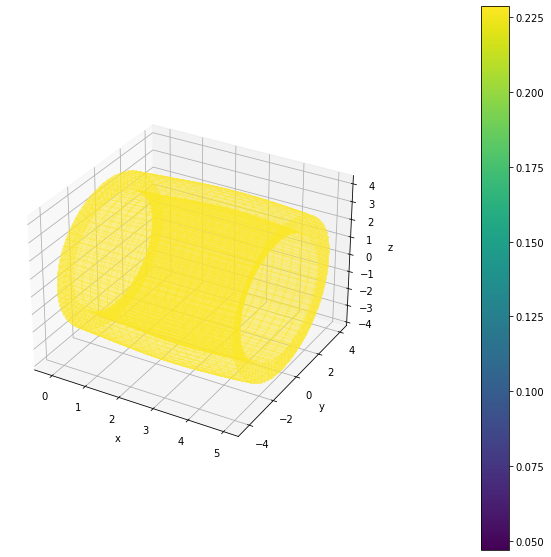

In [107]:
# print deformation plot
get_defplot(u, patches_u, kvs_u)

In [108]:
solution

[array([0.00843853, 0.02338213, 0.00722844, ..., 0.05354845, 0.07548294,
        0.08758907])]

In [111]:
loading = [1e-4, 2.5e-4, 4.0e-4, 4.5e-4, 5e-4] # 6e-4]

In [112]:
loading = [1e-4, 2e-4, 3e-4, 3.5e-4, 4e-4]

In [113]:
#initial value
u= np.zeros(dd)

epsilon= 1e-2 #1e-6

### Linear elasticity for largest loading
loading_value = loading[-1]*500 # take last loading value
neu_data = [(0,'bottom',gN), (1,'bottom',gN), (2,'bottom',gN), (3,'bottom',gN)] # set neumann data
A, M, b = ass_nonlinsystem(u)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
rhs= LS.complete(LS.b)
r0= np.transpose(rhs).dot(M.dot(rhs)) #L2-norm
#r0 = np.linalg.norm(LS.b) # initial residual
print("Norm of rhs for max loading: {}".format(r0))
print("Tolerance:                   {}".format(r0*epsilon))
###

    

Norm of rhs for max loading: 0.040001950075176915
Tolerance:                   0.00040001950075176914


 
 
 1. loading: 0.0001 

r1= 0.002500121879698557
1
use SuperLU
0.07184394147443969
grad_k*p_k= -0.07184394147443968
Start line search
  0. alpha between 0 and None
alpha= 1
residual =  2.044443407802834e-05
 
 
 2. loading: 0.0002 

r1= 0.00255216757024247
1
use SuperLU
0.06995468085853462
grad_k*p_k= -0.21052453064131277
Start line search
  0. alpha between 0 and None
alpha= 1
residual =  1.9899991323424218e-05
 
 
 3. loading: 0.0003 

r1= 0.0025462352996338494
1
use SuperLU
0.06919524965340368
grad_k*p_k= -0.3441413392390674
Start line search
  0. alpha between 0 and None
alpha_int= 0.5
  1. alpha between 0 and 1
alpha_int= 0.25
  2. alpha between 0 and 0.5
alpha_int= 0.125
  3. alpha between 0 and 0.25
alpha_int= 0.0625
  4. alpha between 0 and 0.125
alpha_int= 0.03125
alpha= None
residual =  0.004059822083936758
2
use SuperLU
-0.006711424721023796
Matrix is not positive definite! 

grad_k*p_k= -0.22729842920418464
Start line search
  0. alpha between 0 and None
alpha= 1
residual

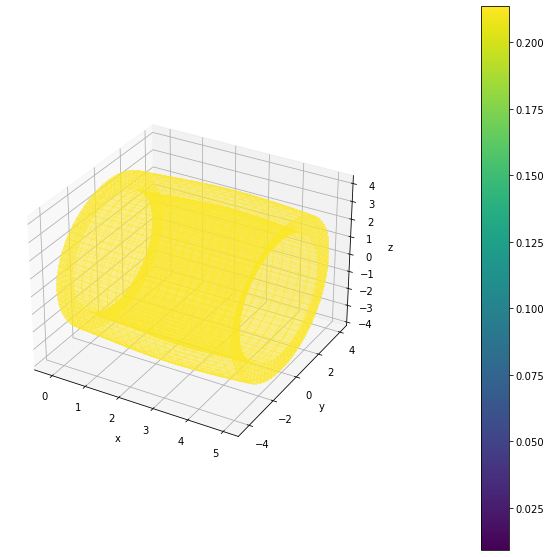

In [114]:
# solve nonlinear system
#initial value
#u= np.zeros(dd)

#epsilon= 1e-1 #1e-2 #1e-6

solutions= []
stepsizes =[] 
ud_array = []
iter_counts = []


# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    loading_value = loading[t]*500
    neu_data = [(0,'bottom',gN), (1,'bottom',gN), (2,'bottom',gN), (3,'bottom',gN)] 
    
    # first residuum
    A, M, b= ass_nonlinsystem(u)
    LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
    rhs= LS.complete(LS.b)
    r1= np.transpose(rhs).dot(M.dot(rhs)) #L2-norm
    #r1= np.linalg.norm(LS.b) # rhs of undeformed system
    print('r1=', r1)

    count= 0
    while True:
        count+=1
        print(count)

        # Assemble matrices and rhs in every iteration step
        A, M, b= ass_nonlinsystem(u)
        LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system

        # # solve system # #
        #u_d= solvers.make_solver(LS.A).dot(LS.b)
        u_d = make_solver_orig(LS.A).dot(LS.b) 

        # check if matrix is positive definite in a particular direction u_d
        if LS.b.dot(u_d) <= 0:
            print(LS.b.dot(u_d)) #transpose(LS.b)*A*LS.b
            print('Matrix is not positive definite! \n')
            #u_d =LS.b
        else:
            print(LS.b.dot(u_d))

        # complete system dependent solution
        u_d = LS.complete(u_d)
        
        print( 'grad_k*p_k=',  np.dot(grad_J(u), u_d))
        
        #print('J(u)=', J(u))

        # # do Wolfe-Powell line search # # 
        #alpha= Wolfe_LineSearch(J, grad_J, u, u_d) 
        alpha= Armijo(J, grad_J, u, u_d) 
        #alpha= line_search(J, grad_J, u, u_d) # use integrated line search (scipy)
        print('alpha=', alpha)
        if alpha == None:
            alpha = 0.5
            u += alpha * u_d # alpha=0.5 (ignore line search)    
        else:
            u += alpha * u_d

            
        # compute new non-linear residuum
        A, M, b = ass_nonlinsystem(u)
       
        
        LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
        rhs= LS.complete(LS.b)
        r = np.transpose(rhs).dot(M.dot(rhs)) #L2-norm
        #r = np.linalg.norm(LS.b) # compute residuum
        print('residual = ', r)

        #----------------------------------------------------#
        ud_array.append(u_d)
        normed_du= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        #normed_du = np.linalg.norm(u_d)
        #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
        stepsize_du = alpha * normed_du # times alpha
        #stepsize_du = abs(normed_du0-normed_du)
        stepsizes.append(stepsize_du)
        #---------------------------------------------------#

        if r < epsilon* r0: # break condition # r < epsilon* r1:
            break
        elif count == 30:
            break
  
    ud_array.append(u_d) 
    solutions.append(LS.restrict(u))
    iter_counts.append(count)
        
# print deformation plot
get_defplot(u, patches_u, kvs_u)

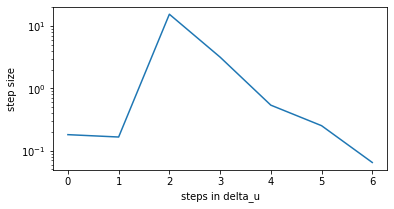

In [115]:
# plot history of step sizes
figsize(6,3)
fig, ax = plt.subplots()
yscale('log')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(stepsizes);
xlabel('steps in delta_u'); ylabel('step size');

In [116]:
s_cts= shape(iter_counts)[0]

In [117]:
s_sol= shape(solutions)[0]

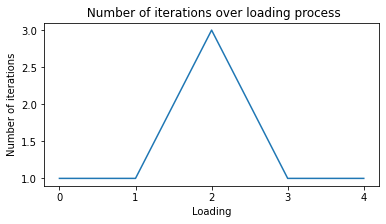

In [118]:
figsize(6,3)
fig, ax= plt.subplots()

plot(range(s_cts), iter_counts)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title(' Number of iterations over loading process');
xlabel('Loading'); ylabel('Number of iterations');

In [132]:
"""Visualization functions."""
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection


def animate_field_3d(fields, patches_u, kvs_u, vrange=None, res=50,cmap=None, interval=50, progress=False):
    """Animate a sequence of scalar fields over a geometry."""
    
    figsize(10,10)
    fig = plt.figure()
    ax = plt.axes(projection ='3d') #,xlim=(0, 2), ylim=(-0.5, 0.5)
    
    fields = list(fields)
    ar= np.linspace(1,20, s_sol)
    factor = ar[0]
    vrange = None

    # first solution
    u= LS.complete(fields[0])
    
    #Split solution vector into displacement components
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:2*MP_u.numdofs]
    u3 = u[2*MP_u.numdofs:3*MP_u.numdofs]
   
    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]
    u3_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u3)
           for p in range(len(patches_u))]
    
    def plotline(pts, capstyle='butt'):
            C = np.sqrt(np.power(pts[..., 1], 2) + np.power(pts[..., 2],2))
            vrange = (C.min(), C.max())
            ax.plot_surface(factor*pts[..., 0], factor*pts[..., 1], factor*pts[..., 2], linewidth=0, antialiased=False, shade = False, alpha = 0.3, facecolors=cm.viridis(C), vmin=vrange[0], vmax=vrange[1])
            ax.set_xlim3d(left=0, right=5.5)
            ax.set_ylim3d(bottom=-4.5, top=4.5)
            ax.set_zbound(lower=-4.5, upper=4.5)
            
            #ax.set_xlim3d(left=0, right=1.5)
            #ax.set_ylim3d(bottom=-0.5, top=0.5)
            #ax.set_zlim3d(bottom=-0.5, top=0.5)
            #ax.set_zbound(lower=-0.5, upper=0.5)
            
    
     # visualization per patch
    for (u1_func, u2_func, u3_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 
        supp = geo.support
        
        gridx = np.linspace(supp[0][0], supp[0][1], 2) # e.g. linespace(0, 1, 2)
        gridy = np.linspace(supp[1][0], supp[1][1], 2)
        gridz = np.linspace(supp[2][0], supp[2][1], 2)

        meshx = np.linspace(supp[0][0], supp[0][1], res) # e.g. linespace(0, 1, 50)
        meshy = np.linspace(supp[1][0], supp[1][1], res)
        meshz = np.linspace(supp[2][0], supp[2][1], res)
        
        
        ygridxz = (meshx, gridy, meshz)
        zgridxy = (meshx, meshy, gridz)
        
        # y-grid 
        dis1 = u1_func.grid_eval(ygridxz) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(ygridxz) #y-value
        dis3 = u3_func.grid_eval(ygridxz) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid
      
        C = np.sqrt(np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        vrange = (C.min(), C.max())
        
        pts = grid_eval(geo, ygridxz) + dis  # + displacement y-coord
        plotline(pts[:, 0, :], capstyle='round')
        for j in range(1, pts.shape[1] - 1):
            plotline(pts[:, j, :])
        plotline(pts[:, -1, :], capstyle='round')
        
        ##'''
        # z-grid
        dis1 = u1_func.grid_eval(zgridxy) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(zgridxy) #y-value
        dis3 = u3_func.grid_eval(zgridxy) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid   

        pts = grid_eval(geo, zgridxy) + dis # # + displacement z-coord
        plotline(pts[:, :, 0], capstyle='round')
        for k in range(1, pts.shape[2] - 1): 
            plotline(pts[:, :, k])
        plotline(pts[:, :, -1],capstyle='round')
    
    norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])   
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, pad=0.2)
    #plt.show()
  
    #fig.colorbar(quadmesh, ax=ax);
    #colorbar();
    tqdm = vis.utils.progress_bar(progress)
    pbar = tqdm(total=len(fields))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
    
    def anim_func(i):
        plt.cla()
        
        vrange= None
        factor = ar[i] # choose factor for deformation plot
        u = LS.complete(fields[i])

        #Split solution vector into displacement components
        u1 = u[:MP_u.numdofs] 
        u2 = u[MP_u.numdofs:2*MP_u.numdofs]
        u3 = u[2*MP_u.numdofs:3*MP_u.numdofs]

        # restrict solution to each individual patch - BSpline functions
        u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
               for p in range(len(patches_u))]
        u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
               for p in range(len(patches_u))]
        u3_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u3)
               for p in range(len(patches_u))]
        
             # visualization per patch
        for (u1_func, u2_func, u3_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 

            # y-grid 
            dis1 = u1_func.grid_eval(ygridxz) #x-value evaluated on 3-dim grid
            dis2 = u2_func.grid_eval(ygridxz) #y-value
            dis3 = u3_func.grid_eval(ygridxz) #z-value
            dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid

            C = np.sqrt(np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))

            pts = grid_eval(geo, ygridxz) + dis  # + displacement y-coord
            plotline(pts[:, 0, :], capstyle='round')
            for j in range(1, pts.shape[1] - 1):
                plotline(pts[:, j, :])
            plotline(pts[:, -1, :], capstyle='round')

            # z-grid
            dis1 = u1_func.grid_eval(zgridxy) #x-value evaluated on 3-dim grid
            dis2 = u2_func.grid_eval(zgridxy) #y-value
            dis3 = u3_func.grid_eval(zgridxy) #z-value
            dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid   

            #C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
            #vrange = (C.min(), C.max())
            #norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])

            pts = grid_eval(geo, zgridxy) + dis # # + displacement z-coord
            plotline(pts[:, :, 0], capstyle='round')
            for k in range(1, pts.shape[2] - 1): 
                plotline(pts[:, :, k])
            plotline(pts[:, :, -1],capstyle='round')
        
            pbar.update()
            if i == len(u) - 1:
                pbar.close()
        #vrange = (C.min(), C.max())
        #norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
            
    return animation.FuncAnimation(plt.gcf(), anim_func, frames=len(fields), interval=interval, repeat=False)

24it [00:08,  2.95it/s]                      


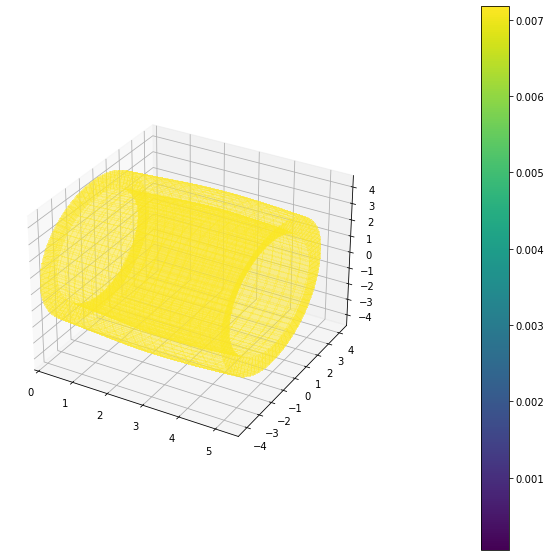

In [133]:
from IPython.display import HTML

figsize(14, 4)
#fields = [ud_array[tt] for tt in range(s_sol)]
fields = [solutions[tt] for tt in range(s_sol)] ## time steps
HTML(animate_field_3d(fields, patches_u, kvs_u, res=20, interval=535, progress=True).to_html5_video())

In [121]:
#split the solution into its components (displacement in x- and y- direction)
# visualization per patch , 2D only!
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib.ticker import LinearLocator
from matplotlib import cm
### 3d surface

def get_defplotC(u, patches_u, kvs_u, grid=2, gridx=None, gridy=None, gridz= None,
             res=20, linewidth=None, **kwargs):
    
    #u= LS.complete(u)
    """Split solution vector into displacement components."""
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:2*MP_u.numdofs]
    u3 = u[2*MP_u.numdofs:3*MP_u.numdofs]
   
    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]
    u3_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u3)
           for p in range(len(patches_u))]
    
    figsize(10,10)
    #fig, ax = plt.subplots()
    fig = plt.figure()
    ax = plt.axes(projection ='3d')
    vrange = None
    
     # visualization per patch
    for (u1_func, u2_func, u3_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 

        if gridx is None: gridx = grid
        if gridy is None: gridy = grid
        if gridz is None: gridz = grid
        supp = geo.support
        
        # if gridx/gridy is not an array, build an array with given number of ticks
        if np.isscalar(gridx):
            gridx = np.linspace(supp[0][0], supp[0][1], gridx) # e.g. linespace(0, 1, 10)
        if np.isscalar(gridy):
            gridy = np.linspace(supp[1][0], supp[1][1], gridy)
        if np.isscalar(gridz):
            gridz = np.linspace(supp[2][0], supp[2][1], gridz)

        meshx = np.linspace(supp[0][0], supp[0][1], res) # e.g. linespace(0, 1, 50)
        meshy = np.linspace(supp[1][0], supp[1][1], res)
        meshz = np.linspace(supp[2][0], supp[2][1], res)

        def plotlineC(pts, C, capstyle='butt'):
            #C = np.sqrt(np.power(pts[..., 1], 2) + np.power(pts[..., 2],2))
            #print(shape(C))
            vrange = (C.min(), C.max())
            #vrange = (0, 1.5e-5)
            
            norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
            ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], linewidth=0, antialiased=False, shade = False, alpha = 0.3,facecolors=cm.viridis(C), vmin=vrange[0], vmax=vrange[1])
            #ax.plot_wireframe(pts[..., 0], pts[..., 1], pts[..., 2], linewidth=1, color='grey') # grid
            #ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], facecolors=colors, linewidth=0) # checkerboard
        
        #xgridyz = (gridx , meshy, meshz)
        xgridyz = (gridx,gridx, gridx)
        ygridxz = (meshx, gridy, meshz)
        zgridxy = (meshx, meshy, gridz)
        
        # y-grid 
        dis1 = u1_func.grid_eval(ygridxz) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(ygridxz) #y-value
        dis3 = u3_func.grid_eval(ygridxz) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid
    
        pts = grid_eval(geo, ygridxz) + dis  # + displacement y-coord
    
        #C = np.sqrt( np.power(dis[..., 0], 2)+np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        #vrange = (C.min(), C.max())
        #norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
        #C = C[:, 0, :]
      
        plotlineC(pts[:, 0, :], C[:, 0, :])
        for j in range(1, pts.shape[1] - 1):
            plotlineC(pts[:, j, :], C[:, j, :])
        plotlineC(pts[:, -1, :], C[:, -1, :])

        # z-grid
        dis1 = u1_func.grid_eval(zgridxy) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(zgridxy) #y-value
        dis3 = u3_func.grid_eval(zgridxy) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid   
        
        pts = grid_eval(geo, zgridxy) + dis # # + displacement z-coord
        C = np.sqrt(np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        #vrange = (C.min(), C.max())
        #norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
        #C = C[:, :, 0]
        
        plotlineC(pts[:, :, 0],C[:, :, 0])
        for k in range(1, pts.shape[2] - 1): 
            plotlineC(pts[:, :, k], C[:, :, k])
        plotlineC(pts[:, :, -1], C[:, :, -1])
        
    #C = np.sqrt( np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
    #C = np.sqrt( np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
    vrange = (C.min(), C.max())
    #vrange = (0, 1.5e-5)
    norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, pad=0.2)
    
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
    plt.show()

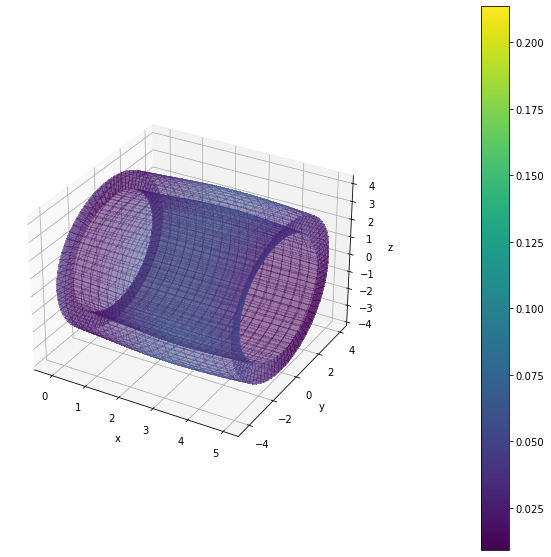

In [122]:
# print deformation plot
get_defplotC(u, patches_u, kvs_u)

In [134]:
#incremental loading
#loading = [5e-5, 6e-5, 7e-5, 8e-5, 9e-5]#, 1e-4] #, 1.25e-4]
loading = [5e-2, 6e-2, 7e-2, 8e-2] # 5e-4]

# set loading_value (used in 1st iteration, lin. problem)
loading_value = loading[-1]

#incremental loading
neu_data = [(0,'bottom',gN), (1,'bottom',gN), (2,'bottom',gN), (3,'bottom',gN)] 

In [150]:
# solve linearized system 
### first iteration ###
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]

#initial value
u= np.zeros(dd)
solution= []
sol=[]

t=0
### first iteration ###
A,M, b= ass_nonlinsystem(u)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
r0= np.linalg.norm(LS.b) # rhs of undeformed system
print('r0=', r0)

u_d = make_solver_orig(LS.A).dot(LS.b) 
u_d = LS.complete(u_d)
u += u_d


A,M, b= ass_nonlinsystem(u)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system


r= np.linalg.norm(LS.b) # compute residuum
print('residual = ', r)

###-----------------###--------------------###
sol = [u]
solution = [LS.restrict(u)]
# norm of delta u in first step
normed_du0= np.linalg.norm(u_d)/np.sqrt(len(u_d))
###----------------###---------------------###

r0= 0.34728223521816587
use SuperLU
residual =  0.050303235856523916


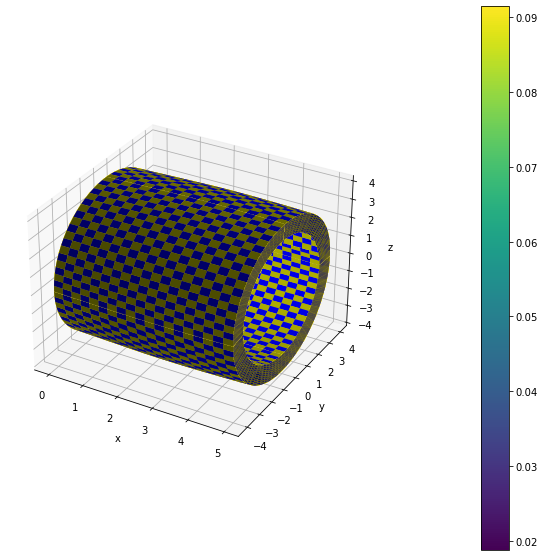

In [151]:
# print deformation plot
get_defplot(u, patches_u, kvs_u)

In [48]:
# minimize residuum, Euclidean norm

Norm of rhs for max loading: 0.34728223521816587
Tolerance:                   3.472822352181659e-06
 
 
 1. loading: 0.05 

1
Residual = 0.21705139701135368
use SuperLU
0.04711130894458035: Matrix is positive definite; use Newton direction.
grad_k*p_k= -0.09422261788916056
Start Wolfe line search
  0. alpha between 0 and 1
     alpha = 1 gives 0.019644234440786567
     alpha neither too big, nor too small
alpha = 1
residual = 0.019644234440786567
2
use SuperLU
0.00038589594676458527: Matrix is positive definite; use Newton direction.
grad_k*p_k= -0.0007717918935291701
Start Wolfe line search
  0. alpha between 0 and 1
     alpha = 1 gives 2.2714866079361663e-05
     alpha neither too big, nor too small
alpha = 1
residual = 2.2714866079361663e-05
3
use SuperLU
5.159651410033366e-10: Matrix is positive definite; use Newton direction.
grad_k*p_k= -1.0319302820066663e-09
Start Wolfe line search
  0. alpha between 0 and 1
     alpha = 1 gives 6.765105522568117e-09
     alpha neither too big

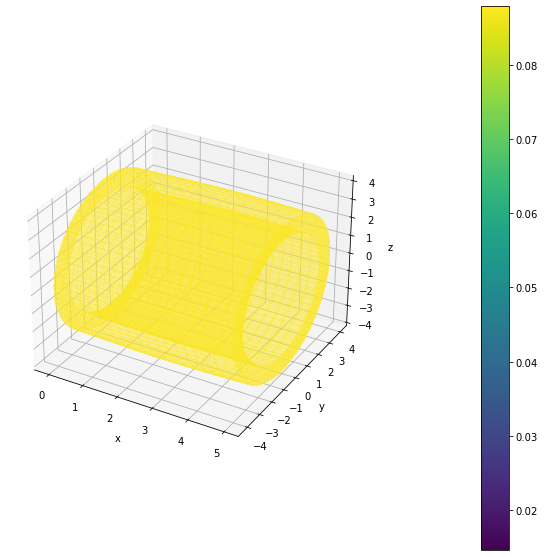

In [137]:
# solve linearized variational problem

#loading = [1e-4, 2e-4, 3e-4, 3.5e-4, 4e-4]#, 2.4e-4, 3.e-4, 4.e-4, 5e-4, 1e-3, 2e-3, 3e-3] 
#loading = [4e-4]

#initial value
u= np.zeros(dd)

epsilon= 1e-5 #1e-6

solutions= []
stepsizes= [] 
ud_array = []
iter_counts = []

### Linear elasticity for largest loading
loading_value = loading[-1] # take last loading value
neu_data = [(0,'bottom',gN), (1,'bottom',gN), (2,'bottom',gN), (3,'bottom',gN)] # set neumann data

A, M, b = ass_nonlinsystem(u)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
r0 = np.linalg.norm(LS.b) # initial residual
print("Norm of rhs for max loading: {}".format(r0))
print("Tolerance:                   {}".format(r0*epsilon))
###


# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    loading_value = loading[t]
    neu_data = [(0,'bottom',gN), (1,'bottom',gN), (2,'bottom',gN), (3,'bottom',gN)] 
    
    #if t>0:
    #    u *= loading_value / loading[t-1]
    
    count = 0
    rejected = False
    while True:
        count+=1
        print(count)

        # Assemble matrices and rhs in every iteration step
        if count == 1:
            A, M, b = ass_nonlinsystem(u)
            LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
            r = np.linalg.norm(LS.b) # compute residuum
            print('Residual =',r)

        # # solve system # #
        #u_d= solvers.make_solver(LS.A).dot(LS.b)
        u_d = make_solver_orig(LS.A).dot(LS.b) 

        # check if matrix is positive definite in a particular direction u_d
        #sp = LS.b.dot(u_d)
        #sp = LS.b.dot(LS.A.T@u_d) # transpose A: AT* A*b ?
        sp = LS.b.dot(LS.A@u_d) # For the residual,...
        #if LS.b.dot(u_d) <= 0:
        if sp <= 0 or rejected: 
            print('{}: Matrix is not positive definite (or rejected); use gradient direction anyway!'.format(sp))
            u_d = LS.b
            rejected = False
        else:
            print('{}: Matrix is positive definite; use Newton direction.'.format(sp))
            
        # complete system dependent solution
        u_d = LS.complete(u_d)

        # # do Wolfe-Powell line search # # 
        alpha = None
        #alpha = Wolfe_LineSearch(J, grad_J, u, u_d) 
        
        def eval_norm(x):
            A, M, b = ass_nonlinsystem(x)
            LS = assemble.RestrictedLinearSystem(A, b, bc)
            return np.linalg.norm(LS.b) ** 2
        def eval_norm_grad(x):
            A, M, b = ass_nonlinsystem(x)
            LS = assemble.RestrictedLinearSystem(A, b, bc)
            return LS.complete((-2) * LS.A.T @ LS.b)
        
        print( 'grad_k*p_k=',  np.dot(eval_norm_grad(u), u_d))
        alpha = Wolfe_LineSearch_st(eval_norm, eval_norm_grad, u, u_d, 1) 
        
        #alpha = line_search(J, grad_J, u, u_d) # use integrated line search (scipy)
        print('alpha =', alpha)
        if alpha != None:
            unew = u + alpha * u_d
            # compute new non-linear residuum
            A, M, b = ass_nonlinsystem(unew)
            LS = assemble.RestrictedLinearSystem(A, b, bc)
            rnew = np.linalg.norm(LS.b)
            if np.linalg.norm(LS.b) > r:
                print("New residual would be {}. Reject this alpha!".format(rnew))
                alpha = None
        
        if alpha == None:           
            print('Use simple line search:')
            #u += 0.5 * u_d # alpha=0.5 (ignore line search)
            # Lets try to do gradient search
            alpha = 1.
            rnew = r+1
            while rnew > r and alpha > 1e-4:
                unew = u + alpha * u_d
                # compute new non-linear residuum
                A, M, b = ass_nonlinsystem(unew)
                LS = assemble.RestrictedLinearSystem(A, b, bc)
                rnew = np.linalg.norm(LS.b) # compute residuum
                print('  alpha {} gives residual {}'.format(alpha,rnew))
                alpha /= 2
            if rnew > r:
                alpha = None
                print("alpha =", alpha)
                if rejected:
                    break # No way to continue !?
                else:
                    alpha = 0
                    rejected = True
            alpha *= 2 # double alpha
            if alpha >= 1:
                alpha = 2.
                rlast = rnew
                while alpha < 10000 and rnew <= rlast:
                    unew = u + alpha * u_d
                    # compute new non-linear residuum
                    A, M, b = ass_nonlinsystem(unew)
                    LS = assemble.RestrictedLinearSystem(A, b, bc)
                    rlast = rnew
                    rnew = np.linalg.norm(LS.b) # compute residuum
                    print('  alpha {} gives residual {}'.format(alpha,rnew))
                    alpha *= 2 # double alpha
                alpha /= 4 # quater alpha

            print("alpha =", alpha)            
            
        u += alpha * u_d            

        # compute new non-linear residuum
        A, M, b = ass_nonlinsystem(u)
        LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
        rold = r
        r = np.linalg.norm(LS.b) # compute residuum
        print('residual =', r)

        #----------------------------------------------------#
        ud_array.append(u_d)
        normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
        stepsize_du = alpha * normed_du # times alpha
        stepsizes.append(stepsize_du)
        #---------------------------------------------------#

        if r < epsilon * r0: # break condition
            break
        elif count == 30:
            break
    #
    ud_array.append(u_d) 
    solutions.append(LS.restrict(u))
    iter_counts.append(count)
        
# print deformation plot
get_defplot(u, patches_u, kvs_u)

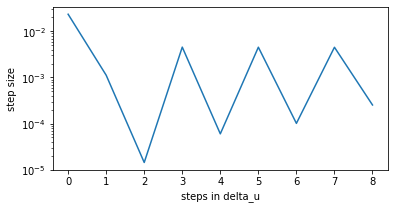

In [138]:
# plot history of step sizes
figsize(6,3)
yscale('log')
plot(stepsizes);
xlabel('steps in delta_u'); ylabel('step size');

In [139]:
s_cts= shape(iter_counts)[0]

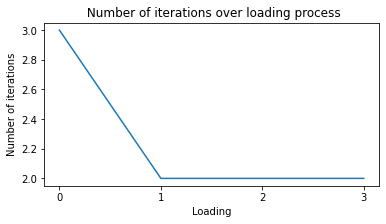

In [140]:
figsize(6,3)
fig, ax= plt.subplots()

plot(range(s_cts), iter_counts)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title(' Number of iterations over loading process');
xlabel('Loading'); ylabel('Number of iterations');

In [53]:
#with L2_Norm

Norm of rhs for max loading: 0.0064003120120283055
Tolerance:                   6.400312012028305e-05
 
 
 1. loading: 0.05 

1
Residual = 0.002500121879698557
use SuperLU
0.04711130894458035: Matrix is positive definite; use Newton direction.
grad_k * ud_k= -0.09422261788916056
Start Wolfe line search
  0. alpha between 0 and 1
     alpha = 1 gives 0.019644234440786567
     alpha neither too big, nor too small
alpha = 1
residual = 2.044443407802834e-05
 
 
 2. loading: 0.06 

1
Residual = 0.00012676956055914754
use SuperLU
0.0024168648652969794: Matrix is positive definite; use Newton direction.
grad_k * ud_k= -0.004833729730593943
Start Wolfe line search
  0. alpha between 0 and 1
     alpha = 1 gives 0.0007542735324023408
     alpha neither too big, nor too small
alpha = 1
residual = 3.072369539168239e-08
 
 
 3. loading: 0.07 

1
Residual = 0.00010015826662577049
use SuperLU
0.0018893625322126376: Matrix is positive definite; use Newton direction.
grad_k * ud_k= -0.0037787250644252

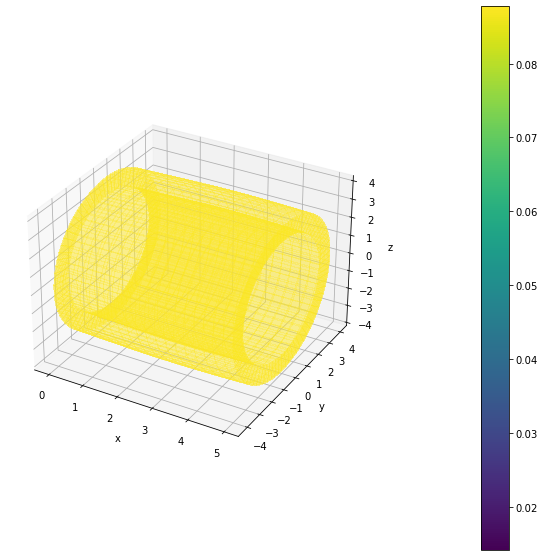

In [145]:
# solve linearized variational problem

#loading = [1e-4, 2e-4, 3e-4, 3.5e-4, 4e-4]#, 2.4e-4, 3.e-4, 4.e-4, 5e-4, 1e-3, 2e-3, 3e-3] 
#loading = [4e-4]

#initial value
u= np.zeros(dd)

epsilon= 1e-2# 1e-5

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []


### Linear elasticity for largest loading
loading_value = loading[-1] # take last loading value
neu_data = [(0,'bottom',gN), (1,'bottom',gN), (2,'bottom',gN), (3,'bottom',gN)] # set neumann data

A, M, b = ass_nonlinsystem(u)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
r0= np.transpose(LS.complete(LS.b)).dot(M.dot(LS.complete(LS.b))) #L2-norm
#0 = np.linalg.norm(LS.b) # initial residual
print("Norm of rhs for max loading: {}".format(r0))
print("Tolerance:                   {}".format(r0*epsilon))
###


# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    loading_value = loading[t]
    neu_data = [(0,'bottom',gN), (1,'bottom',gN), (2,'bottom',gN), (3,'bottom',gN)] 
    
    #if t>0:
    #    u *= loading_value / loading[t-1]
    
    count = 0
    rejected = False
    while True:
        count+=1
        print(count)

        # Assemble matrices and rhs in every iteration step
        if count == 1:
            A, M, b = ass_nonlinsystem(u)
            LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
            r= np.transpose(LS.complete(LS.b)).dot(M.dot(LS.complete(LS.b))) #L2-norm
            #r = np.linalg.norm(LS.b) # compute residuum
            print('Residual =',r)

        # # solve system # #
        #u_d= solvers.make_solver(LS.A).dot(LS.b)
        u_d = make_solver_orig(LS.A).dot(LS.b) 

        # check if matrix is positive definite in a particular direction u_d
        #sp = LS.b.dot(u_d)
        #sp = LS.b.dot(LS.A.T@u_d) # transpose A: AT* A*b ?
        sp = LS.b.dot(LS.A@u_d) # For the residual,...
        #if LS.b.dot(u_d) <= 0:
        if sp <= 0 or rejected: 
            print('{}: Matrix is not positive definite (or rejected); use gradient direction anyway!'.format(sp))
            u_d = LS.b
            rejected = False
        else:
            print('{}: Matrix is positive definite; use Newton direction.'.format(sp))
            
        # complete system dependent solution
        u_d = LS.complete(u_d)

        # # do Wolfe-Powell line search # # 
        alpha = None
        #alpha = Wolfe_LineSearch(J, grad_J, u, u_d) 
        
        def eval_norm(x):
            A, M, b = ass_nonlinsystem(x)
            LS = assemble.RestrictedLinearSystem(A, b, bc)
            #return np.transpose(LS.complete(LS.b)).dot(M.dot(LS.complete(LS.b))) **2 #L2-norm
            return np.linalg.norm(LS.b) ** 2
        def eval_norm_grad(x):
            A, M, b = ass_nonlinsystem(x)
            LS = assemble.RestrictedLinearSystem(A, b, bc)
            return LS.complete((-2) * LS.A.T @ LS.b)
        
        print( 'grad_k * ud_k=',  np.dot(eval_norm_grad(u), u_d))
       
        # Line-Search 
        alpha = Wolfe_LineSearch_st(eval_norm, eval_norm_grad, u, u_d, 1) 

        print('alpha =', alpha)
        if alpha != None:
            unew = u + alpha * u_d
            # compute new non-linear residuum
            A, M, b = ass_nonlinsystem(unew)
            LS = assemble.RestrictedLinearSystem(A, b, bc)
            rnew = np.transpose(LS.complete(LS.b)).dot(M.dot(LS.complete(LS.b))) #L2-norm
            #rnew = np.linalg.norm(LS.b)
            #if np.linalg.norm(LS.b) > r:
            if rnew > r:
                print("New residual would be {}. Reject this alpha!".format(rnew))
                alpha = None
        
        if alpha == None:           
            print('Use simple line search:')
            #u += 0.5 * u_d # alpha=0.5 (ignore line search)
            # Lets try to do gradient search
            alpha = 1.
            rnew = r+1
            while rnew > r and alpha > 1e-4:
                unew = u + alpha * u_d
                # compute new non-linear residuum
                A, b = ass_nonlinsystem(unew)
                LS = assemble.RestrictedLinearSystem(A, b, bc)
                rnew = np.transpose(LS.complete(LS.b)).dot(M.dot(LS.complete(LS.b))) #L2-norm
                #rnew = np.linalg.norm(LS.b) # compute residuum
                print('  alpha {} gives residual {}'.format(alpha,rnew))
                alpha /= 2
            if rnew > r:
                alpha = None
                print("alpha =", alpha)
                if rejected:
                    break # No way to continue !?
                else:
                    alpha = 0
                    rejected = True
            alpha *= 2 # double alpha
            if alpha >= 1:
                alpha = 2.
                rlast = rnew
                while alpha < 10000 and rnew <= rlast:
                    unew = u + alpha * u_d
                    # compute new non-linear residuum
                    A, b = ass_nonlinsystem(unew)
                    LS = assemble.RestrictedLinearSystem(A, b, bc)
                    rlast = rnew
                    rnew = np.transpose(LS.complete(LS.b)).dot(M.dot(LS.complete(LS.b))) #L2-norm
                    #rnew = np.linalg.norm(LS.b) # compute residuum
                    print('  alpha {} gives residual {}'.format(alpha,rnew))
                    alpha *= 2 # double alpha
                alpha /= 4 # quater alpha

            print("alpha =", alpha)            
            
        u += alpha * u_d            

        # compute new non-linear residuum
        A, M, b = ass_nonlinsystem(u)
        LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
        rold = r #?
        r = np.transpose(LS.complete(LS.b)).dot(M.dot(LS.complete(LS.b))) #L2-norm
        #r = np.linalg.norm(LS.b) # compute residuum
        print('residual =', r)

        #----------------------------------------------------#
        ud_array.append(u_d)
        normed_du= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
        stepsize_du = alpha * normed_du # times alpha
        stepsizes.append(stepsize_du)
        #---------------------------------------------------#

        if r < epsilon * r0: # break condition
            break
        elif count == 30:
            break
    #
    ud_array.append(u_d) 
    solutions.append(LS.restrict(u))
    iter_counts.append(count)
        
# print deformation plot
get_defplot(u, patches_u, kvs_u)

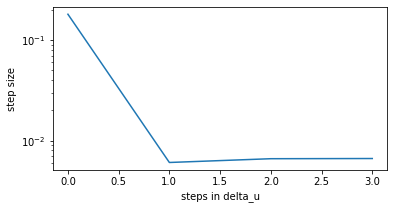

In [146]:
# plot history of step sizes
figsize(6,3)
yscale('log')
plot(stepsizes);
xlabel('steps in delta_u'); ylabel('step size');

In [147]:
s_cts= shape(iter_counts)[0]

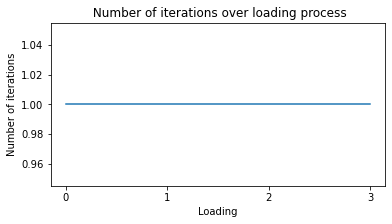

In [148]:
figsize(6,3)
fig, ax= plt.subplots()

plot(range(s_cts), iter_counts)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title(' Number of iterations over loading process');
xlabel('Loading'); ylabel('Number of iterations');